# Contenido<a id='contenido'></a>
* [Introducción](#int)
    * [Objetivo](#obj)
* [Iniciación de datos](#ini)
    * [Examina datos](#exa)
* [Procesamiento datos](#pro)
    * [Pre-procesamiento de datos](#pre)
        * [Valores ausentes](#nan)
    * [Procesamiento de características](#car)
        * [Codificación One-Hot](#cod)
        * [Escalado de caracteristicas](#esc)
* [Exploración gráfica de datos](#exp)
* [Entrenar un modelo](#equi)
    * [Modelo piloto con clases desequilibradas](#mod)
        * [Prueba de consistencia](#pru)
    * [Equilibrio de clases](#equ)
        * [Sobremuestreo](#sob)
        * [Submuestreo](#sub)
    * [Entrenamiento de modelos y mejora la calidad del modelo](#mej)
        * [1-Algoritmo DecisionTreeClassifier](#al1)
        * [2-Algoritmo Random Forest Classifier](#al2)
        * [3-Algoritmo Logistic Regression](#al3)
    * [Curva ROC](#cur)
* [Conclusión general](#con)

# Introducción <a id='intr'></a>

Los clientes de *Beta Bank* se están yendo cada mes, poco a poco. Los banqueros descubrieron que es más barato salvar a los clientes existentes que atraer nuevos. Necesitamos predecir si un cliente dejará el banco pronto. Contamos con datos sobre el comportamiento pasado de los clientes y la terminación de contratos con el banco.

## Objetivo <a id='obj'></a>
Crear un modelo para predecir si un cliente dejará el banco. Medir la calidad del modelo usando la métrica F1 y AUC-ROC.

# Iniciación de datos<a id='ini'></a>

Importamos las librerias:

In [1]:
# generales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# machine learning 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree            import DecisionTreeClassifier
from sklearn.ensemble        import RandomForestClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score 
from sklearn.utils import shuffle

Cargamos el dataset:

In [2]:
# carga de datos
try:
    users = pd.read_csv('Churn.csv')
except:
    users = pd.read_csv('datasets/Churn.csv')

## Examina datos<a id='exa'></a>

In [3]:
display(users.head())
print(f'Duplicados: {users.duplicated().sum()}')
users.info()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Duplicados: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


- El dataset contiene 10.000 registros y 14 columnas. 
- Faltan valores en `Tenure`. 
- Los tipos de datos se ven bien. 
- No existen registros duplicados.

### Descripción de los datos <a id='des'></a>

Vamos a entender la información de los clientes del banco. A continuación veamos una descripción de cada columna determinando las características y la variable objetivo:

**Características**

* `RowNumber`: índice de cadena de datos
* `CustomerId`: identificador de cliente único
* `Surname`: apellido
* `CreditScore`: valor de crédito
* `Geography`: país de residencia
* `Gender`: sexo
* `Age`: edad
* `Tenure`: período durante el cual ha madurado el depósito a plazo fijo de un cliente (años)
* `Balance`: saldo de la cuenta
* `NumOfProducts`: número de productos bancarios utilizados por el cliente
* `HasCrCard`: el cliente tiene una tarjeta de crédito (1 - sí; 0 - no)
* `IsActiveMember`: actividad del cliente (1 - sí; 0 - no)
* `EstimatedSalary`: salario estimado

**Objetivo**
* `Exited`: El cliente se ha ido (1 - sí; 0 - no)

# Procesamiento de datos<a id='pro'></a>

## Pre-procesamiento de datos <a id='pre'></a>

Eliminamos la columna `RowNumber` ya que no contiene información relevante.

In [4]:
# eliminamos columnas innecesarias
users = users.drop('RowNumber', axis=1)

Renombramos nombres de todas las columnas.

In [5]:
users.columns

Index(['CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age',
       'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
       'EstimatedSalary', 'Exited'],
      dtype='object')

In [6]:
# Renombramos columnas

users = users.rename(
    columns = {
        'CustomerId':'customer_id', 
        'Surname': 'surname',
        'CreditScore': 'credit_score', 
        'Geography': 'geography', 
        'Gender': 'gender', 
        'Age': 'age',
       'Tenure': 'tenure', 
       'Balance': 'balance', 
       'NumOfProducts': 'num_of_products', 
       'HasCrCard': 'has_cr_card' , 
       'IsActiveMember': 'is_active_member',
       'EstimatedSalary': 'estimated_salary', 
       'Exited': 'exited'
    }
)

users.columns

Index(['customer_id', 'surname', 'credit_score', 'geography', 'gender', 'age',
       'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited'],
      dtype='object')

Listo, las columnas fueron renombradas correctamente.

In [7]:
len(users.customer_id.unique())

10000

Existe 1 registro por cliente es decir un total de 10.000 clientes. 

### Valores ausentes<a id='nan'></a>

Revisemos los NaN en `Tenure`:

In [8]:
users.tenure.value_counts(dropna=False, normalize=True)

1.0     0.0952
2.0     0.0950
8.0     0.0933
3.0     0.0928
5.0     0.0927
7.0     0.0925
NaN     0.0909
4.0     0.0885
9.0     0.0882
6.0     0.0881
10.0    0.0446
0.0     0.0382
Name: tenure, dtype: float64

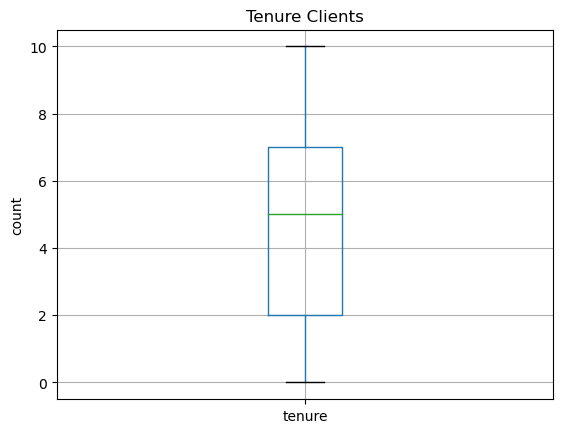

Mean: 5


In [9]:
# distribución de datos 

users.boxplot('tenure')
plt.ylabel('count')
plt.title('Tenure Clients')
plt.show()

print(f'Mean: {users.tenure.mean():0.0f}')

*Tenure* tiene una distribución normal de datos. El 9% son NaN y no podemos determinar por qué hace falta esta información. Para que estos NaN no afecten nuestro modelo, vamos a rellenarlos con la media condicionada a otra característica por ejemplo al número de productos que tenga el cliente `num_of_products`.

Primero observemos cómo se distribuyen los datos de los registros NaN frente a la variable objetivo `exited`

In [10]:
# Distribución en `exited` 1 o 0 donde `tenure` es NaN
users.query('tenure.isna()').exited.value_counts(normalize=True)

0    0.79868
1    0.20132
Name: exited, dtype: float64

In [11]:
# Distribución en `exited` 1 o 0 
users.exited.value_counts(normalize=True)

0    0.7963
1    0.2037
Name: exited, dtype: float64

Ok, tenemos que en los registros NaN de `tenure` están el 80% son 0 y el 20% son 1 en la variable objetivo *exited*. Tengamos en cuenta esta información para comprobar que no cambie despúes de realizar el imputamiento.

In [12]:
# Relleno a valores NaN
users['tenure'] = users.groupby('num_of_products')['tenure'].transform(lambda x: x.fillna(x.mean())).round()

# comprobamos que ya no hay valores ausentes
print(users.tenure.isna().sum())
users.tenure.value_counts(dropna=True, normalize=True)

0


5.0     0.1836
1.0     0.0952
2.0     0.0950
8.0     0.0933
3.0     0.0928
7.0     0.0925
4.0     0.0885
9.0     0.0882
6.0     0.0881
10.0    0.0446
0.0     0.0382
Name: tenure, dtype: float64

In [13]:
# Comprobamos la distribución en `exited` 1 o 0 donde `tenure'
users.exited.value_counts(normalize=True)

0    0.7963
1    0.2037
Name: exited, dtype: float64

Después de imputar valores NaN nuestra variable objetivo no tiene mayores cambios, de forma general podemos comprobar que el 80% tiene 0 osea no dejaron el banco y el 20% tienen 1 es decir se fueron.

## Procesamiento de características <a id='car'></a>

Vamos a revisar los datos y realizar codificación de características categóricas con One-Hot. Además realizaremos un escalado de datos.

In [14]:
users.head(10)

,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


### Codificación One-Hot<a id='cod'></a>

Realizaremos codificacion de variables categóricas usando One-Hot. Las columnas categóricas a las que se aplicará la codificación son las siguientes: 
- `geography`, 
- `gender`, 
- `num_of_products`,
- `has_cr_card`, 
- `is_active_member`. 

No hemos observado la existencia de variables ordinales que requiera codificación ordinal.

In [15]:
# Codificar características categóricas con One-Hot 

users_code = pd.get_dummies(data=users, columns=['geography', 'gender', 'num_of_products', 'has_cr_card', 'is_active_member'])
display(users_code.head())

,customer_id,surname,credit_score,age,tenure,balance,estimated_salary,exited,geography_France,geography_Germany,...,gender_Female,gender_Male,num_of_products_1,num_of_products_2,num_of_products_3,num_of_products_4,has_cr_card_0,has_cr_card_1,is_active_member_0,is_active_member_1
0,15634602,Hargrave,619,42,2.0,0.00,101348.88,1,1,0,...,1,0,1,0,0,0,0,1,0,1
1,15647311,Hill,608,41,1.0,83807.86,112542.58,0,0,0,...,1,0,1,0,0,0,1,0,0,1
2,15619304,Onio,502,42,8.0,159660.80,113931.57,1,1,0,...,1,0,0,0,1,0,0,1,1,0
3,15701354,Boni,699,39,1.0,0.00,93826.63,0,1,0,...,1,0,0,1,0,0,1,0,1,0
4,15737888,Mitchell,850,43,2.0,125510.82,79084.10,0,0,0,...,1,0,1,0,0,0,0,1,0,1


Hemos aplicado la codificación de variables categóricas mediante One'Hot. La tabla final `users_code` tiene 21 columnas totales.

### Escalado de características <a id='esc'></a>

Ahora vamos a aplicar un escalado en los datos con la estandarización de datos usando `StandardScaler` a las siguientes columnas numéricas:

- `credit_score`, 
- `age`, 
- `tenure`, 
- `balance`, 
- `estimated_salary`. 

In [16]:
# Escalado de características

numeric = ['credit_score', 'age', 'tenure', 'balance', 'estimated_salary']

scaler = StandardScaler()
scaler.fit(users_code[numeric])

users_code[numeric] = scaler.transform(users_code[numeric])

users_code.head()

,customer_id,surname,credit_score,age,tenure,balance,estimated_salary,exited,geography_France,geography_Germany,...,gender_Female,gender_Male,num_of_products_1,num_of_products_2,num_of_products_3,num_of_products_4,has_cr_card_0,has_cr_card_1,is_active_member_0,is_active_member_1
0,15634602,Hargrave,-0.326221,0.293517,-1.086246,-1.225848,0.021886,1,1,0,...,1,0,1,0,0,0,0,1,0,1
1,15647311,Hill,-0.440036,0.198164,-1.448581,0.117350,0.216534,0,0,0,...,1,0,1,0,0,0,1,0,0,1
2,15619304,Onio,-1.536794,0.293517,1.087768,1.333053,0.240687,1,1,0,...,1,0,0,0,1,0,0,1,1,0
3,15701354,Boni,0.501521,0.007457,-1.448581,-1.225848,-0.108918,0,1,0,...,1,0,0,1,0,0,1,0,1,0
4,15737888,Mitchell,2.063884,0.388871,-1.086246,0.785728,-0.365276,0,0,0,...,1,0,1,0,0,0,0,1,0,1


Listo! Hemos realizado la escala de datos. Los datos son actualizados en la variable `users_code`.

## Exploración gráfica de datos<a id='exp'></a>

Exploremos gráficamente las variables categóricas y numéricas:

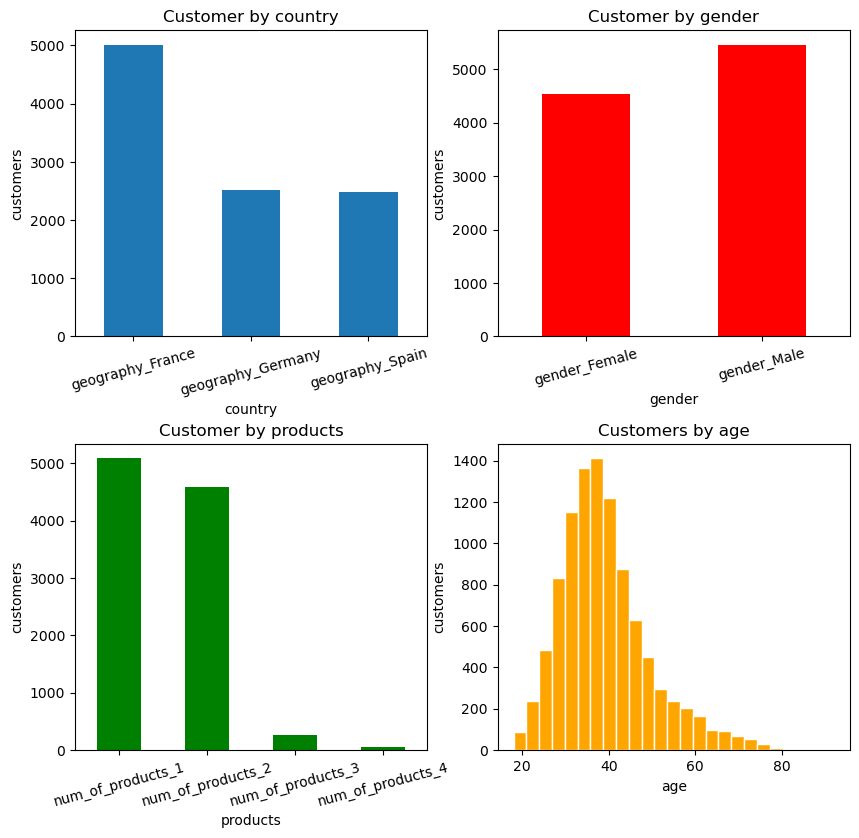

In [17]:
# Gráficos para revisar las distribuciones de los datos 

fig, ((a,b),(c,d))= plt.subplots(figsize=(10,8),
                                 nrows=2, 
                                 ncols=2)

# Gráfico 1
users_code[['geography_France', 'geography_Germany', 
                                'geography_Spain']].sum().plot(kind='bar',
                                                               ax=a, 
                                                               rot=15)
a.set_xlabel('country')
a.set_ylabel('customers')
a.set_title('Customer by country')


# Gráfico 2
users_code[['gender_Female', 'gender_Male']].sum().plot(kind='bar', 
                                                        ax=b, 
                                                        rot=15,
                                                        color='red')
b.set_xlabel('gender')
b.set_ylabel('customers')
b.set_title('Customer by gender')


# Gráfico 3
users_code[['num_of_products_1', 'num_of_products_2', 
            'num_of_products_3', 'num_of_products_4']].sum().plot(kind='bar', 
                                                                  ax=c, 
                                                                  rot=15,
                                                                  color='green')
c.set_xlabel('products')
c.set_ylabel('customers')
c.set_title('Customer by products')


# Gráfico 4
users.age.plot(kind='hist', 
               bins=25, 
               ax=d, 
               color='orange',
               edgecolor='white')
d.set_xlabel('age')
d.set_ylabel('customers')
d.set_title('Customers by age')

# Ajustes
plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=1, 
                    wspace=0.2, 
                    hspace=0.35)

plt.show()

*Lectura de los primeros 4 gráficos:*
- Clientes por pais: los clientes están distribuidos en 3 paises: Francia, Alemania y España, la mayoría de los clientes son franceses.
- Clientes por género: hay más clientes hombres que mujeres.
- Clientes por productos: los clientes han contratado de 1 a 4 productos del banco. La mayoría de los clientes tienen 1 solo producto, un buen grupo tienen 2. La minoría contrata de 3 a 4 productos.
- Clientes por edad: la mayoría de clientes tienen entre 32 y 42 años aproximadamente. Muy pocos clientes tienen más de 70 o menos de 20 años.

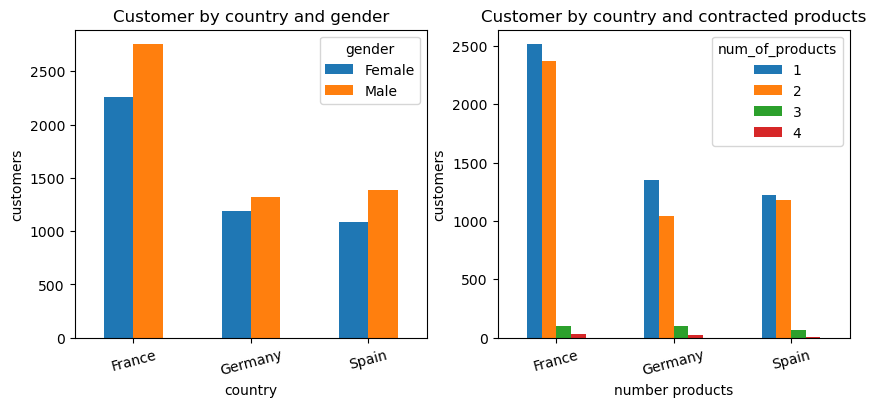

In [18]:
group_customers_1 = users.pivot_table(index=['geography'], columns=['gender'], values='customer_id', aggfunc='count')
group_customers_2 = users.pivot_table(index=['geography'], columns=['num_of_products'], values='customer_id', aggfunc='count')

fig, (a,b)= plt.subplots(figsize=(10,4),
                                 nrows=1, 
                                 ncols=2)

# Gráfico 5
group_customers_1.plot(kind='bar', 
                       rot=15, 
                       ax=a)
a.set_title('Customer by country and gender')
a.set_xlabel('country')
a.set_ylabel('customers')

# Gráfico 6
group_customers_2.plot(kind='bar', 
                       rot=15, 
                       ax=b)
b.set_title('Customer by country and contracted products')
b.set_xlabel('number products')
b.set_ylabel('customers')

plt.show()


*Lectura de los gráficos:*
- Clientes de cada pais por género: en cada país los clientes mayoritarios son los hombres.
- Clientes de cada pais por número de productos del banco que contrataron: En cada pais la mayor parte de los clientes tienen entre 1 y 2 productos.

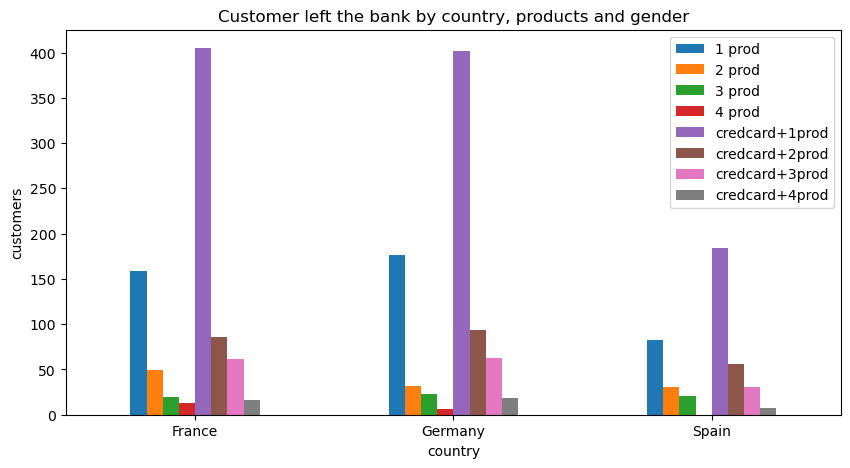

In [19]:
group_customers_3 = users.query('exited==1').pivot_table(index=['geography'],
                                                         columns=['has_cr_card','num_of_products'], 
                                                         values='customer_id', 
                                                         aggfunc='count')

group_customers_3.plot(kind='bar', 
                       rot=0,
                       figsize=(10,5))

plt.title('Customer left the bank by country, products and gender')
plt.xlabel('country')
plt.ylabel('customers')
plt.legend(['1 prod', '2 prod', '3 prod', '4 prod', 
            'credcard+1prod', 'credcard+2prod', 'credcard+3prod', 'credcard+4prod'])
plt.show()

*Lectura de los gráfico:*

El gráfico nos muestra como están distribuidos **los clientes que dejaron el banco**. Los paises con más clientes que dejaron el banco son los de Francia y Alemánia, esto tiene lógica y es proporcional, puesto que como vimos en los gráficos anteriores la mayoría de los clientes son Franceses y Alemanes. 

En los 3 paises se coincide con algo, que estos clientes que dejaron el banco en su mayoría tenían 1 tarjeta de crédito y 1 producto contratado del banco. 

Por otro lado, los clientes con 4 productos contratados indistíntamente si poseen o no una tarjeta de crédito son minoría entre este grupo de clientes de cada pais que decidieron abandonar el banco.

Revisemos si existen o no correlaciones entre nuestras variables.

In [20]:
display(users.corr(numeric_only=True).round(2))

,customer_id,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
customer_id,1.00,0.01,0.01,-0.02,-0.01,0.02,-0.01,0.00,0.02,-0.01
credit_score,0.01,1.00,-0.00,-0.00,0.01,0.01,-0.01,0.03,-0.00,-0.03
age,0.01,-0.00,1.00,-0.01,0.03,-0.03,-0.01,0.09,-0.01,0.29
tenure,-0.02,-0.00,-0.01,1.00,-0.01,0.01,0.03,-0.03,0.01,-0.02
balance,-0.01,0.01,0.03,-0.01,1.00,-0.30,-0.01,-0.01,0.01,0.12
num_of_products,0.02,0.01,-0.03,0.01,-0.30,1.00,0.00,0.01,0.01,-0.05
has_cr_card,-0.01,-0.01,-0.01,0.03,-0.01,0.00,1.00,-0.01,-0.01,-0.01
is_active_member,0.00,0.03,0.09,-0.03,-0.01,0.01,-0.01,1.00,-0.01,-0.16
estimated_salary,0.02,-0.00,-0.01,0.01,0.01,0.01,-0.01,-0.01,1.00,0.01
exited,-0.01,-0.03,0.29,-0.02,0.12,-0.05,-0.01,-0.16,0.01,1.00


Los valores que observamos en la tabla no representa la existencia de correlaciones entre nuestras variables numérica. Es decir, no hemos encontrado variables candidatas a ser predictoras para nuestro modelo.

# Entrenar un modelo<a id='ent'></a>

## Modelo piloto con clases desequilibradas <a id='mod'></a>

Para examinar el equilibrio vamos a entrenar un modelo y revisar equilibrio de clases.

In [21]:
# Dividimos características en la variable features y el objetivo en target
features = users_code.drop(['exited', 'surname'], axis=1)
target = users_code['exited']

# Segmentación de datos train 60%, valid 20% y test 20%
features_train, features_valid, target_train, target_valid = train_test_split(features,       target,       test_size=0.40, random_state=12345)
features_valid, features_test,  target_valid, target_test =  train_test_split(features_valid, target_valid, test_size=0.50, random_state=12345)

In [22]:
# Entrenamos nuestro modelo con datos de prueba: features_train, target_train.
model = DecisionTreeClassifier(random_state=12345)
model.fit(features_train, target_train)

# Predecimos con nuestros datos de validación y guardamos predicciones en predicted_valid
predicted_valid = model.predict(features_valid)

# Medimos la calidad del modelo
print(f' Accuracy {accuracy_score(target_valid, predicted_valid):.4f}')

 Accuracy 0.7815


Tenemos una exactitud de 78%. Revisemos si nuestro modelo es bueno realizando una prueba de cordura.


### Prueba de consistencia<a id='pru'></a>

Para evaluar la cordura del modelo, verifiquemos con qué frecuencia la característica de destino contiene la clase positiva 1 y la clase negativa 0. 

0    0.7963
1    0.2037
Name: exited, dtype: float64


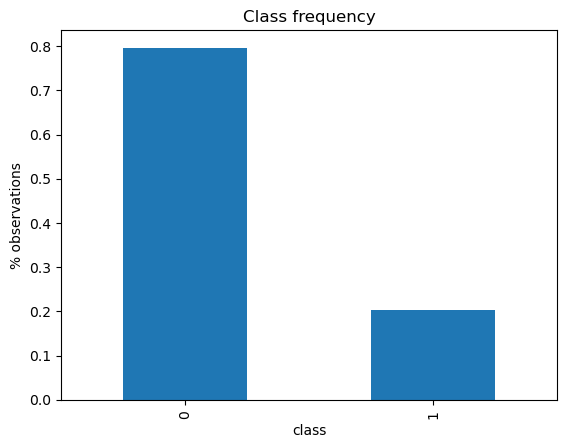

In [23]:
class_frequency = target.value_counts(normalize=True)
print(class_frequency)

class_frequency.plot(kind='bar')
plt.title('Class frequency')
plt.xlabel('class')
plt.ylabel('% observations')
plt.show()

Observamos que la clase 0 es la más frecuente con un 80% y la clase 1 es la más rara con un 20%, es decir 2 de 10 clientes han dejado el banco. Notablemente tenemos los datos desbalanceados.

Ahora analizaremos las frecuencias de clase de las predicciones del árbol de decisión.

0    0.7865
1    0.2135
dtype: float64


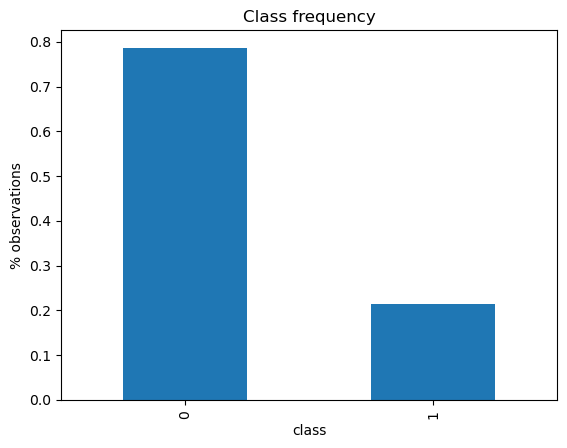

In [24]:
predicted_valid = pd.Series(model.predict(features_valid))

class_frequency = predicted_valid.value_counts(normalize=True)
print(class_frequency)

class_frequency.plot(kind='bar')
plt.title('Class frequency')
plt.xlabel('class')
plt.ylabel('% observations')
plt.show()

Las frecuencias de clases de las predicciones del modelo entrenado, son cercanas a las frecuencias naturales de nuestros datos con un 78% clase más frecuente y 21% clase menos frecuente.

Para efectibizar nuestra prueba de cordura, crearemos un modelo constante que predice la clase 0 (la más frecuente). Realizaremos las predicciones y mostraremos la exactitud.

In [25]:
# Modelo constante de predicción de clase frecuente 0
target_pred_constant = pd.Series(0, index=target.index)

print(f'Accuracy {accuracy_score(target, target_pred_constant):.1%}')

Accuracy 79.6%


Como resultado nuestro modelo constante obtuvo el 79.6% esto es mayor frente al modelo de Arbol de Decision, por lo que no pasa la prueba de cordura.

Como observamos nuestras clases 0 y 1 de nuestro objetivo está desbalanceado, esto podría afectar nuestros modelos de predicción, por lo que realizaremos un balanceo de clases.

## Equilibrio de clases <a id='equ'></a>

Con el objetivo de equilibrar el desbalanceo de clases aplicaremos en nuestro conjunto de datos de entrenamiento *features_train* y *target_train*, 2 técnicas de balanceo de clases: *sobremuestreo* y *submuestreo*.

-  *Sobremuestreo*: consiste en agregar datos a la clase minoritaria con el objetivo de equilibrar el conjunto desbalanceado de datos.
-  *Submuestreo*: consiste en eliminar datos de la clase mayoritaria hasta alcanzar el equilibrio con la clase minoritaria.

Para cada técnica realizaremos:
- Crear una función para aplicar la técnica
- Aplicar la técnica a nuestros conjuntos de entrenamiento
- Entrenar un modelo
- Verificar la calidad del modelo.
- Escoger la técnica adecuada.

### Sobremuestreo<a id='sob'></a>

In [26]:
# Función sobremuestreo

def upsample(features, target, repeat):
    
    # Dividir el conjunto de datos de entrenamiento en observaciones negativas y positivas;
    features_zeros = features[target == 0]
    features_ones  = features[target == 1]
    target_zeros = target[target == 0]
    target_ones  = target[target == 1]

    # Duplicar las observaciones positivas (las que tienen ocurrencias raras) varias veces 
    # Crear una nueva muestra de entrenamiento basada en los datos obtenidos
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled   = pd.concat([target_zeros]   + [target_ones]   * repeat)

    # Barajar los datos
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)

    return features_upsampled, target_upsampled

#----------------------------------------------

In [27]:
# balanceamos los datos de entrenamiento con el sobremuestreo
features_upsampled, target_upsampled = upsample(features_train, target_train, 5)

print(f'         Train dataset: features={features_train.shape},  target={target_train.shape}')
print(f'Train balanced dataset: features={features_upsampled.shape}, target={target_upsampled.shape}')

         Train dataset: features=(6000, 19),  target=(6000,)
Train balanced dataset: features=(10784, 19), target=(10784,)


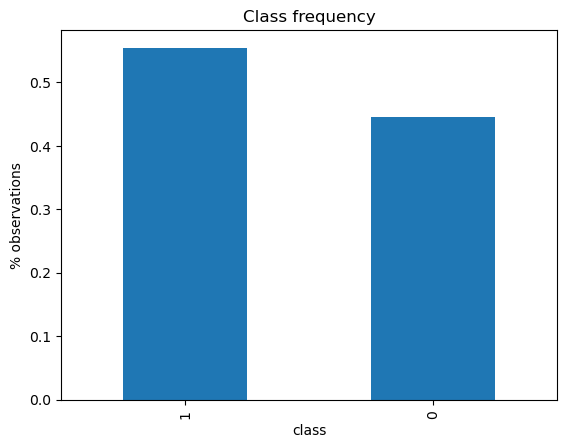

In [28]:
target_upsampled.value_counts(normalize=True).plot(kind='bar')
plt.title('Class frequency'), 
plt.xlabel('class')
plt.ylabel('% observations')
plt.show()

El sobremuestro ha sido aplicado y nuestros datos crecieron, ahora tenemos 10784 registros, antes teniamos 6000 registros. Las clases se visualizan distribuidas más cercanas que antes del sobremuestreo.

Nuevos conjuntos de datos de entrenamiento obtenidos:
- `features_upsampled`
- `target_upsampled`

### Submuestreo<a id='sub'></a>

In [29]:
# Función submuestreo

def downsample(features, target, fraction):

    # Dividir el conjunto de datos de entrenamiento en observaciones negativas y positivas
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    # Soltar al azar una parte de las observaciones negativas
    # Crear una nueva muestra de entrenamiento basada en los datos obtenidos después de la caída
    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled   = pd.concat([  target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])

    # Mezclar los datos. Asegúrate de que los datos positivos no sigan a los negativos: esto dificultará que los algoritmos aprendan.
    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=12345)

    return features_downsampled, target_downsampled

#----------------------------------------------

In [30]:
# balanceamos los datos de entrenamiento con el submuestreo
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.1)

print(f'         Train dataset: features={features_train.shape}, target={target_train.shape}')
print(f'Train balanced dataset: features={features_downsampled.shape}, target={target_downsampled.shape}')

         Train dataset: features=(6000, 19), target=(6000,)
Train balanced dataset: features=(1676, 19), target=(1676,)


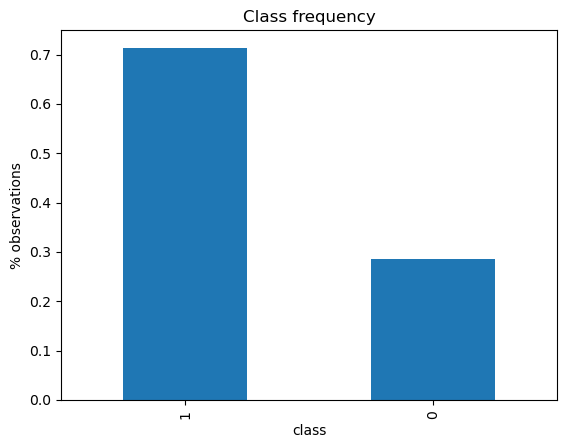

In [31]:
target_downsampled.value_counts(normalize=True).plot(kind='bar')
plt.title('Class frequency'), 
plt.xlabel('class')
plt.ylabel('% observations')
plt.show()

El submuestro ha sido aplicado y nuestros datos disminuyeron, es decir se eliminaron registros, ahora tenemos 1676 registros de 6000 registros. Las clases se visualizan distribuidas más cercanas que antes del submuestreo, sin embargo no es mejor que cuando aplicamos el sobremuestreo.

Nuevos conjuntos de datos de entrenamiento obtenidos:
- `features_downsampled`
- `target_downsampled`

## Entrenamiento de modelos y mejora la calidad<a id='mej'></a>

Vamos a entrenar varios modelos predictivos con nuestros conjuntos de datos de entrenamiento con clases balanceadas y desbalanceadas. Las variables a usar son las siguientes: 

Sin equilibrar
- `features_train`
- `target_train`

Con sobremuestreo
- `features_upsampled`
- `target_upsampled`

Con submuestreo
- `features_downsampled`
- `target_downsampled`

Además crearemos una tabla llamada `summary_models` donde guardaremos todos los modelos entrenados y sus métricas.

In [32]:
summary_models = pd.DataFrame(columns=['name', 'version', 'model', 'metric_f1']).set_index(keys=['name','version'])
summary_models

,,model,metric_f1
name,version,,


### 1-Algoritmo Decision Tree Classifier <a id='al1'></a>

Vamos a entrenar 3 versiones de modelo con el algoritmo de *árbol de decisión clasificador*:
- Modelo 1 con clases desequilibradas, 
- Modelo 2 con clases equilibradas mediante sobremuestreo
- Modelo 3 con clases equilibradas mediante submuestreo. 
    
En cada modelo realizaremos optimización de hiperparámetros: random_state=12345, max_depth= 1-10.

In [33]:
# Modelos 1-3 Árbol de decisión clasificador

for version in [1, 2, 3]:
    best_score = 0
    for depth in range(1,11):
        # creación de modelo de entrenamiento mediante arbol de decisión
        model = DecisionTreeClassifier(random_state=12345, max_depth=depth)

        # entrena el modelo con el conjunto de entrenamiento
        if version == 1:
            model.fit(features_train, target_train)
        elif version == 2:
            model.fit(features_upsampled, target_upsampled)
        elif version == 3:
            model.fit(features_downsampled, target_downsampled)

        # predicción para datos de valiación
        prediction_valid = model.predict(features_valid)
        
        # métrica
        f1 = f1_score(target_valid, prediction_valid)

        if f1 > best_score:
            best_score = f1
            best_model = model

    print(f'\nModel {version} score F1 {best_score}')
    display(best_model)

    # guardamos los resultados
    model_name = str(model).split('(')[0] # nombre del modelo
    sampling = ['no', 'upsampled', 'downsampled']
    summary_models.loc[(model_name, sampling[version-1]),:] = {'model':best_model, 'metric_f1': best_score}
    


Model 1 score F1 0.5834542815674891


DecisionTreeClassifier(max_depth=5, random_state=12345)


Model 2 score F1 0.5900552486187846


DecisionTreeClassifier(max_depth=3, random_state=12345)


Model 3 score F1 0.5144157814871017


DecisionTreeClassifier(max_depth=4, random_state=12345)

### 2-Algoritmo Random Forest Classifier<a id='al2'></a>

Vamos a entrenar 3 versiones de modelo con el algoritmo de *bosque aleatorio clasificador*:
- Modelo 4 con clases desequilibradas, 
- Modelo 5 con clases equilibradas mediante sobremuestreo
- Modelo 6 con clases equilibradas mediante submuestreo. 
    
En cada modelo realizaremos optimización de hiperparámetros a usan:ramdom_state=12345, n_estimators=1-20, max_depth=10-20, 

In [34]:
# Modelos 4-6 Bosque Aleatorio Clasificador 

for version in [1,2,3]:
    best_score = 0
    # Variar el número de arboles tree y la profundidad de cada arbol depth
    for tree in range(1, 20):
        for depth in range(10,20):
            
            # creación del modelo de entrenamiento mediante bosque aleatorio
            model = RandomForestClassifier(random_state=12345, n_estimators=tree, max_depth=depth)

            # entrena el modelo con el conjunto de entrenamiento
            if version == 1:
                model.fit(features_train, target_train)
            elif version == 2:
                model.fit(features_upsampled, target_upsampled)
            elif version == 3:
                model.fit(features_downsampled, target_downsampled)

            # predicción para datos de valiación
            prediction_valid = model.predict(features_valid)

            # métrica
            f1 = f1_score(target_valid, prediction_valid)
            
            if f1 > best_score:
                best_score = f1
                best_model = model

    print(f'\nModel {version+3} score F1 {best_score}')
    display(best_model)

    # guardamos los resultados
    model_name = str(model).split('(')[0] # nombre del modelo
    sampling = ['no', 'upsampled', 'downsampled']
    summary_models.loc[(model_name, sampling[version-1]),:] = {'model': best_model, 'metric_f1': best_score}



Model 4 score F1 0.5829596412556054


RandomForestClassifier(max_depth=13, n_estimators=18, random_state=12345)


Model 5 score F1 0.6060606060606061


RandomForestClassifier(max_depth=18, n_estimators=16, random_state=12345)


Model 6 score F1 0.49086576648133445


RandomForestClassifier(max_depth=11, n_estimators=2, random_state=12345)

### 3-Algoritmo Logistic Regression <a id='al3'></a>

Vamos a entrenar 3 versiones de modelo con el algoritmo de *Regresión Logística*
- Modelo 7 con clases desequilibradas, 
- Modelo 8 con clases equilibradas mediante sobremuestreo
- Modelo 9 con clases equilibradas mediante submuestreo. 
    
En cada modelo realizaremos optimización de hiperparámetros a usan: random_state=12345 y solver= liblinear.

In [35]:
# Regresion Logística

for version in [1, 2, 3]:
    model = LogisticRegression(random_state=12345, solver='liblinear')

    # entrena el modelo con el conjunto de entrenamiento
    if version == 1:
        model.fit(features_train, target_train)
    elif version == 2:
        model.fit(features_upsampled, target_upsampled)
    elif version == 3:
        model.fit(features_downsampled, target_downsampled)

    # predicción para datos de valiación
    prediction_valid = model.predict(features_valid)
        
    # métrica
    f1 = f1_score(target_valid, prediction_valid)
    print(f'\nModel {version+6} score F1 {f1}')
    display(model)

    model_name = str(model).split('(')[0] # nombre del modelo
    sampling = ['no', 'upsampled', 'downsampled']
    summary_models.loc[(model_name, sampling[version-1]),:] = {'model': model, 'metric_f1': f1}


Model 7 score F1 0.0


LogisticRegression(random_state=12345, solver='liblinear')


Model 8 score F1 0.3457402812241522


LogisticRegression(random_state=12345, solver='liblinear')


Model 9 score F1 0.3457402812241522


LogisticRegression(random_state=12345, solver='liblinear')

Revisemos nuestra tabla resumen de modelos entrenados:

In [36]:
display(summary_models)

model  \
name                   version                                                          
DecisionTreeClassifier no           DecisionTreeClassifier(max_depth=5, random_sta...   
                       upsampled    DecisionTreeClassifier(max_depth=3, random_sta...   
                       downsampled  DecisionTreeClassifier(max_depth=4, random_sta...   
RandomForestClassifier no           (DecisionTreeClassifier(max_depth=13, max_feat...   
                       upsampled    (DecisionTreeClassifier(max_depth=18, max_feat...   
                       downsampled  (DecisionTreeClassifier(max_depth=11, max_feat...   
LogisticRegression     no           LogisticRegression(random_state=12345, solver=...   
                       upsampled    LogisticRegression(random_state=12345, solver=...   
                       downsampled  LogisticRegression(random_state=12345, solver=...   

                                   metric_f1  
name                   version                
DecisionTreeClassifier no           0.583454  
                       upsampled    0.590055  
                       downsampled  0.514416  
RandomForestClassifier no            0.58296  
                       upsampled    0.606061  
                       downsampled  0.490866  
LogisticRegression     no                0.0  
                       upsampled     0.34574  
                       downsampled   0.34574

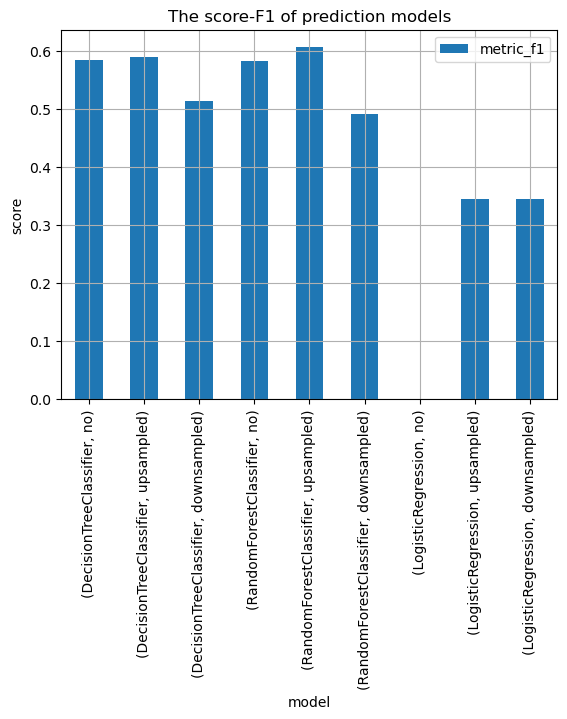

In [37]:
summary_models.plot(kind='bar', grid=True)
plt.title('The score-F1 of prediction models')
plt.xlabel('model')
plt.ylabel('score')
plt.show()

En la tabla resumen *summary_models* tenemos un resumen de 9 modelos entrenados con cada puntaje F1 obtenido. 

Como observamos el mejor modelo es
- *RandomForestClassifier* con un f1 score de **0.60** 
- técnica de *sobremuestreo*
- hiperparámetros: *max_depth=18, n_estimators=16 y random=12345*.
- el modelo entrenado se encuentra guardado en la tabla *summary_models*

El siguiente paso es vertificar F1 con conjunto de datos de prueba `feature_test` y `target_test`

In [38]:
# Obtengamos los modelos guardados en nuestra tabla summary_models
model_random_forest = summary_models.loc[('RandomForestClassifier','upsampled'),:].model

# predicción para datos de valiación
prediction_random_forest = model_random_forest.predict(features_test)
f1 = f1_score(target_test, prediction_random_forest)

# métrica f1
print(f'Random Forest Classifier, score F1 {f1:.6f}')


Random Forest Classifier, score F1 0.572549


Listo, hemos verificado nuestro score F1 con el conjunto de datos de prueba es casi igual, obteniendo un score 0.57, el cual es un poquito mejor al obtenido antes.

## Curva ROC<a id='cur'></a>

La curva ROC (característica operativa del receptor) es un gráfico bidimensional en el que la tasa de falsos positivos se traza en el eje X y la tasa de verdaderos positivos se traza en el eje Y. Las curvas ROC son útiles para visualizar y comparar el rendimiento de los métodos de clasificación.

De acuerdo a la métrica F1 el mejor modelo es Random Forest obteniendo el 0.60, por lo que revisaremos ahora mediante la curva ROC nuestros 3 modelos y veamos mediante la métrica **AUC-ROC** su puntaje y comparemos con la obtenida antes con F1.

In [39]:
# Reseteamos el indice de nuestra tabla para acceder a los datos por un indice más simple
summary_models.reset_index(inplace=True)
summary_models

,name,version,model,metric_f1
0,DecisionTreeClassifier,no,"DecisionTreeClassifier(max_depth=5, random_sta...",0.583454
1,DecisionTreeClassifier,upsampled,"DecisionTreeClassifier(max_depth=3, random_sta...",0.590055
2,DecisionTreeClassifier,downsampled,"DecisionTreeClassifier(max_depth=4, random_sta...",0.514416
3,RandomForestClassifier,no,"(DecisionTreeClassifier(max_depth=13, max_feat...",0.58296
4,RandomForestClassifier,upsampled,"(DecisionTreeClassifier(max_depth=18, max_feat...",0.606061
5,RandomForestClassifier,downsampled,"(DecisionTreeClassifier(max_depth=11, max_feat...",0.490866
6,LogisticRegression,no,"LogisticRegression(random_state=12345, solver=...",0.0
7,LogisticRegression,upsampled,"LogisticRegression(random_state=12345, solver=...",0.34574
8,LogisticRegression,downsampled,"LogisticRegression(random_state=12345, solver=...",0.34574


In [40]:
# Probabilidades de las prediciones de cada modelo

# Obtengamos los modelos guardados en nuestra tabla summary_models y guardemos en variables individualmente
model1 = summary_models.loc[0].model
model2 = summary_models.loc[1].model
model3 = summary_models.loc[2].model
model4 = summary_models.loc[3].model
model5 = summary_models.loc[4].model
model6 = summary_models.loc[5].model
model7 = summary_models.loc[6].model
model8 = summary_models.loc[7].model
model9 = summary_models.loc[8].model

# Aplicar funcion predict_proba
prob1 = model1.predict_proba(features_test)
prob2 = model2.predict_proba(features_test)
prob3 = model3.predict_proba(features_test)
prob4 = model4.predict_proba(features_test)
prob5 = model5.predict_proba(features_test)
prob6 = model6.predict_proba(features_test)
prob7 = model7.predict_proba(features_test)
prob8 = model8.predict_proba(features_test)
prob9 = model9.predict_proba(features_test)

# Probablidades de la clase positiva
prob1_one = prob1[:, 1]
prob2_one = prob2[:, 1]
prob3_one = prob3[:, 1]
prob4_one = prob4[:, 1]
prob5_one = prob5[:, 1]
prob6_one = prob6[:, 1]
prob7_one = prob7[:, 1]
prob8_one = prob8[:, 1]
prob9_one = prob9[:, 1]

# Métrica AUC ROC
auc_roc_1 = roc_auc_score(target_test, prob1_one)
auc_roc_2 = roc_auc_score(target_test, prob2_one)
auc_roc_3 = roc_auc_score(target_test, prob3_one)
auc_roc_4 = roc_auc_score(target_test, prob4_one)
auc_roc_5 = roc_auc_score(target_test, prob5_one)
auc_roc_6 = roc_auc_score(target_test, prob6_one)
auc_roc_7 = roc_auc_score(target_test, prob7_one)
auc_roc_8 = roc_auc_score(target_test, prob8_one)
auc_roc_9 = roc_auc_score(target_test, prob9_one)

print(f'AUC-ROC Model 1: {auc_roc_1:.4f}')
print(f'AUC-ROC Model 2: {auc_roc_2:.4f}')
print(f'AUC-ROC Model 3: {auc_roc_3:.4f}')
print(f'AUC-ROC Model 4: {auc_roc_4:.4f}')
print(f'AUC-ROC Model 5: {auc_roc_5:.4f}')
print(f'AUC-ROC Model 6: {auc_roc_6:.4f}')
print(f'AUC-ROC Model 7: {auc_roc_7:.4f}')
print(f'AUC-ROC Model 8: {auc_roc_8:.4f}')
print(f'AUC-ROC Model 9: {auc_roc_9:.4f}')


AUC-ROC Model 1: 0.8215
AUC-ROC Model 2: 0.8099
AUC-ROC Model 3: 0.8175
AUC-ROC Model 4: 0.8383
AUC-ROC Model 5: 0.8324
AUC-ROC Model 6: 0.7360
AUC-ROC Model 7: 0.5269
AUC-ROC Model 8: 0.4731
AUC-ROC Model 9: 0.4731


Hemos calculado la métrica *AUC-ROC* para nuestros 9 modelos, obteniendo mejores resultados que con F1. Vemos que el modelo #4 que corresponde a *Random Forest* continua siendo el mejor, con un **score de 0.84**, esto nos indica una buena calidad del modelo.

3 mejores modelos según AUC-ROC

- AUC-ROC Model 4: 0.8383
- AUC-ROC Model 5: 0.8324
- AUC-ROC Model 1: 0.8215

Usaremos la curva ROC, y graficaremos los mejores score AUC-ROC es decir de los modelos 4, 5 y 1.

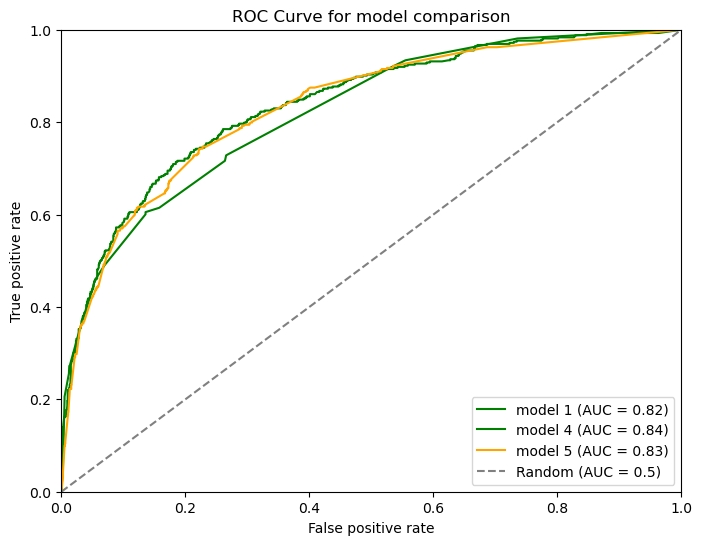

In [41]:
# Con ROC Curve obtenemos de cada modelo: False positive rate, true positive rate, thresholds 
fpr_1, tpr_1, thresholds_1 = roc_curve(target_test, prob1_one)
fpr_4, tpr_4, thresholds_4 = roc_curve(target_test, prob4_one)
fpr_5, tpr_5, thresholds_5 = roc_curve(target_test, prob5_one)

# Graficamos Curva ROC

plt.figure(figsize=(8,6))
plt.xlim([0, 1])
plt.ylim([0, 1])

plt.plot(fpr_1, tpr_1, color="green",  label=f"model 1 (AUC = {auc_roc_1:.2f})")
plt.plot(fpr_4, tpr_4, color="green",  label=f"model 4 (AUC = {auc_roc_4:.2f})")
plt.plot(fpr_5, tpr_5, color="orange", label=f"model 5 (AUC = {auc_roc_5:.2f})")

# Curva ROC para modelo aleatorio
plt.plot([0,1], [0,1], linestyle='--', c='gray', label="Random (AUC = 0.5)")

plt.title('ROC Curve for model comparison')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()
plt.show()

La gráfica nos muestra claramente la calidad de nuestros modelos, confirmando que nuestro modelo *Random Forest Classifier*.

In [42]:
# Mejor modelo
model4

RandomForestClassifier(max_depth=13, n_estimators=18, random_state=12345)

# Conclusión general<a id='con'></a>

Se ha realizado el entrenamiento de un modelo de predicción de clasificación. El proceso se realizó de la siguiente manera:
- Inicialmente realizamos una *exploración gráfica* de las variables. No se obtuvieron correlaciones entre dichas variables pero pudimos observar que los clientes que dejaron el banco en su mayoría tenían 1 tarjeta de crédito y 1 producto contratado del banco. y los clientes con 4 productos contratados indistíntamente si poseen o no una tarjeta de crédito son minoría entre este grupo de clientes de cada pais que decidieron abandonar el banco.
- Entrenamos 9 modelos distintos. Se realizaron versiones diferentes de estos modelos, usando datos desvalanceados y también usando técnicas de *sobremuestreo* y *submuestro*.
- Cada modelo se midió de acuerdo a su score F1 donde usando distintos hiperparámetros en cada algoritmo de entrenamiento.
- Los algoritmos usados fueron:
    - Decision Tree Classifier
    - Random Forest Classifier
    - Logistic Regression
- El *mejor modelo* que obtuvimos de acuerdo a la métrica F1 tiene la siguiente características:
    - Algoritmo Random Forest Classifier.
    - Hiperparámetros: max_depth_13, n_estimators=18, random_state=12345.
    - Métrica F1: **0.60**
    - Métrica AUC-ROC: **0.84** siendo (mejor que F1)
- Mediante gráfica de la curva ROC mostramos el comportamiento respecto a Tasa de Falsos Positivos y Tasa de Verdaderos Positivos en los 3 mejores modelos, por lo que se pudo tener claridad en la calidad del modelo que elegimos como el mejor.

Podemos concluir indicando, que se logró obtener un modelo predictivo acorde al objetivo planteado en este trabajo, por lo que el Banco podrá usar este modelo de predecir si sus clientes dejarán o no el banco, y así poder realizar acciones necesarios para evitar que sus clientes se vayan.